In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import joblib

# Rechargez les données (assurez-vous d'avoir sauvegardé une version nettoyée, sinon refaites les étapes de renommage)
df = pd.read_csv('../data/raw/credit_card_default.csv', header=1)
df = df.rename(columns={'default payment next month': 'TARGET'})

In [2]:
X = df.drop('TARGET', axis=1)
y = df['TARGET']

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,    # 20% des données pour le test
    random_state=42,  # Pour que la séparation soit toujours la même
    stratify=y        # C'EST LE PARAMÈTRE LE PLUS IMPORTANT ICI !
)

In [4]:
# Colonnes catégorielles
categorical_features = ['SEX', 'EDUCATION', 'MARRIAGE']

# Colonnes numériques (on prend tout sauf les catégorielles et l'ID client)
numeric_features = [col for col in X.columns if col not in categorical_features + ['ID']]

# Les variables PAY_X sont ordinales, on les traitera comme numériques pour cette baseline
# On pourrait les traiter différemment dans un modèle plus avancé

In [5]:
# Pipeline pour les variables numériques
numeric_transformer = StandardScaler()

# Pipeline pour les variables catégorielles
categorical_transformer = OneHotEncoder(handle_unknown='ignore') # ignore les catégories non vues à l'entraînement

In [6]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Garde les autres colonnes (ID) intactes
)

In [7]:
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='saga',max_iter=500, random_state=42))
])

In [8]:
# Le pipeline applique le prétraitement et entraîne le modèle sur X_train, y_train
model_pipeline.fit(X_train, y_train)
print("Modèle de référence entraîné !")

Modèle de référence entraîné !


C:\Users\Ahmad\loan\venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [9]:
# Évaluation sur le set de test
accuracy = model_pipeline.score(X_test, y_test)
print(f"Accuracy du modèle de référence sur le set de test : {accuracy:.4f}")

Accuracy du modèle de référence sur le set de test : 0.7793


In [10]:
# Sauvegarder le pipeline dans un fichier
joblib.dump(model_pipeline, 'baseline_logistic_regression_pipeline.pkl')
print("Pipeline sauvegardé !")

Pipeline sauvegardé !


In [11]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [12]:
# Pipeline pour le Random Forest
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Pipeline pour XGBoost
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
])

# Pipeline pour LightGBM
lgbm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(random_state=42))
])

# N'oublions pas notre baseline
lr_pipeline = joblib.load('baseline_logistic_regression_pipeline.pkl')

joblib.dump(xgb_pipeline, 'xgb_pipeline.pkl')

['xgb_pipeline.pkl']

In [13]:
from sklearn.model_selection import StratifiedKFold, cross_validate
import time

# On définit notre stratégie : 5 "plis" stratifiés
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [14]:
scoring_metrics = ['roc_auc', 'accuracy', 'precision_macro', 'recall_macro', 'f1_macro']

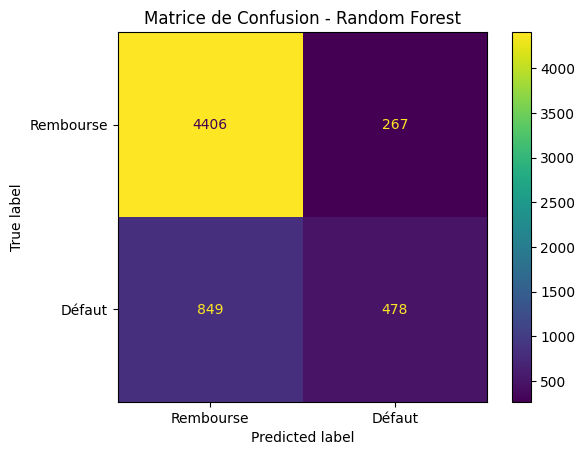

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
rf_pipeline.fit(X_train, y_train)
predictions = rf_pipeline.predict(X_test)

ConfusionMatrixDisplay.from_predictions(y_test, predictions, display_labels=['Rembourse', 'Défaut'])
plt.title('Matrice de Confusion - Random Forest')
plt.show()

In [16]:
# Dictionnaire de nos modèles
models = {
    "Régression Logistique": lr_pipeline,
    "Random Forest": rf_pipeline,
    "XGBoost": xgb_pipeline,
    "LightGBM": lgbm_pipeline
}

results = {}

print("Début de l'évaluation des modèles...")

#for name, model in models.items():
    #start_time = time.time()
    
    ## Exécuter la validation croisée
    #cv_results = cross_validate(model, X_train, y_train, cv=cv_strategy, scoring=scoring_metrics)
    
    #end_time = time.time()
    
    ## Stocker les résultats
    #results[name] = {
        #'ROC AUC (Moyenne CV)': cv_results['test_roc_auc'].mean(),
        #'ROC AUC (Écart-type CV)': cv_results['test_roc_auc'].std(),
        #'Recall (Moyenne CV)': cv_results['test_recall_macro'].mean(),
        #'Precision (Moyenne CV)': cv_results['test_precision_macro'].mean(),
        #'Temps d\'entraînement (s)': end_time - start_time
    #}
    #print(f"{name} évalué en {end_time - start_time:.2f} secondes.")

## Créer un DataFrame à partir des résultats
#results_df = pd.DataFrame(results).T # .T pour transposer le tableau

## Afficher le tableau final
#results_df

Début de l'évaluation des modèles...


LightGBM a le meilleur ROC AUC moyen (0,779) et le meilleur Recall (0,659). Le temps d'entraînement de 13s est bien 
meilleur que celui de RL(230s) et RF(77s) mais est-ce que ça vaut le coup comparé à XGBoost (5s) avec 
des performances quasiment similaires.
Au vu des résultats, le modèle XGBoost semble offrir le meilleur compromis entre une excellente performance-rappel
(ROC AUC de 0.764, Recall de 0,655) et un temps d'entraînement, je le sélectionne donc pour la prochaine étape.

In [19]:
from sklearn.model_selection import GridSearchCV
import shap
import joblib
import xgboost as xgb 
# On suppose que X_train, y_train, etc. sont déjà chargés et prêts
# Et que votre pipeline de prétraitement 'preprocessor' est défini

In [21]:
# On crée un nouveau pipeline avec le classifieur XGBoost non entraîné
# C'est ce pipeline que GridSearchCV va utiliser et régler
xgb_pipeline_for_tuning = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'))
])

# Définition de la grille de recherche
# NOTE : Les noms des paramètres doivent commencer par 'classifier__'
# pour dire à scikit-learn que ce sont des paramètres du classifieur DANS le pipeline.
param_grid = {
    'classifier__n_estimators': [100, 200, 300] ,         # Nombre d'arbres
    'classifier__max_depth': [2, 3, 4],                # Profondeur maximale des arbres
    'classifier__learning_rate': [0.05, 0.1, 0.2],       # Taux d'apprentissage
    'classifier__subsample': [0.8, 1.0]             # Fraction des données à utiliser pour chaque arbre
}

In [22]:
# On réutilise notre stratégie de validation croisée
cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42) # n_splits=3 pour aller plus vite

grid_search = GridSearchCV(
    estimator=xgb_pipeline_for_tuning,
    param_grid=param_grid,
    scoring='roc_auc',  # La métrique qu'on veut maximiser
    cv=cv_strategy,
    n_jobs=-1,          # Utilise tous les cœurs du processeur pour accélérer
    verbose=2           # Affiche la progression
)

print("Début de la recherche des meilleurs hyperparamètres...")
grid_search.fit(X_train, y_train)
print("Recherche terminée!")

Début de la recherche des meilleurs hyperparamètres...
Fitting 3 folds for each of 54 candidates, totalling 162 fits


C:\Users\Ahmad\loan\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:18:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Recherche terminée!


In [23]:
# 1. La Stratégie d'Évaluation (StratifiedKFold)
# Pour éviter qu'un modèle soit "bon par chance", on le teste plusieurs fois (ici 5 fois, n_splits=5)
# sur différentes parties des données d'entraînement. C'est ce qu'on appelle la validation croisée (Cross-Validation).
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 2. L'Arbitre (GridSearchCV)
grid_search = GridSearchCV(
    estimator=xgb_pipeline_for_tuning,  # Le concurrent : notre chaîne de montage XGBoost.
    param_grid=param_grid,              # Les règles : le menu des réglages à tester.
    scoring='roc_auc',                  # Le critère de victoire : on cherche à maximiser le score ROC AUC.
    cv=cv_strategy,                     # La méthode de test : notre validation croisée.
    n_jobs=-1,                          # Logistique : utilise tous les cœurs de ton processeur pour aller plus vite.
    verbose=2                           # Commentaire : affiche la progression pour ne pas s'ennuyer.
)

# 3. Lancement de la compétition !
# C'est LA ligne qui prend du temps. La machine travaille dur pour tester toutes les combinaisons.
print("--- Début de la recherche des meilleurs hyperparamètres ---")
grid_search.fit(X_train, y_train)
print("--- Recherche terminée ! ---")

# 4. Annonce des résultats
# On affiche le score du grand gagnant et sa "recette" exacte.
print(f"\nMeilleur score ROC AUC : {grid_search.best_score_:.4f}")
print("\nMeilleurs hyperparamètres trouvés :")
print(grid_search.best_params_)

--- Début de la recherche des meilleurs hyperparamètres ---
Fitting 5 folds for each of 54 candidates, totalling 270 fits


C:\Users\Ahmad\loan\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:28:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- Recherche terminée ! ---

Meilleur score ROC AUC : 0.7837

Meilleurs hyperparamètres trouvés :
{'classifier__learning_rate': 0.05, 'classifier__max_depth': 4, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}


Meilleur score ROC AUC : 0.7837

Meilleurs hyperparamètres trouvés :
{'classifier__learning_rate': 0.05, 'classifier__max_depth': 4, 'classifier__n_estimators': 200, 'classifier__subsample': 0.8}

In [24]:
# 1. Récupérer le meilleur modèle, prêt à l'emploi.
final_model = grid_search.best_estimator_

# 2. Le "mettre sous vide" pour plus tard.
# joblib.dump prend notre modèle (final_model) et le sauvegarde dans un fichier.
# On pourra le recharger plus tard avec joblib.load() sans avoir à tout ré-entraîner.
joblib.dump(final_model, 'final_model_xgboost.pkl')

['final_model_xgboost.pkl']

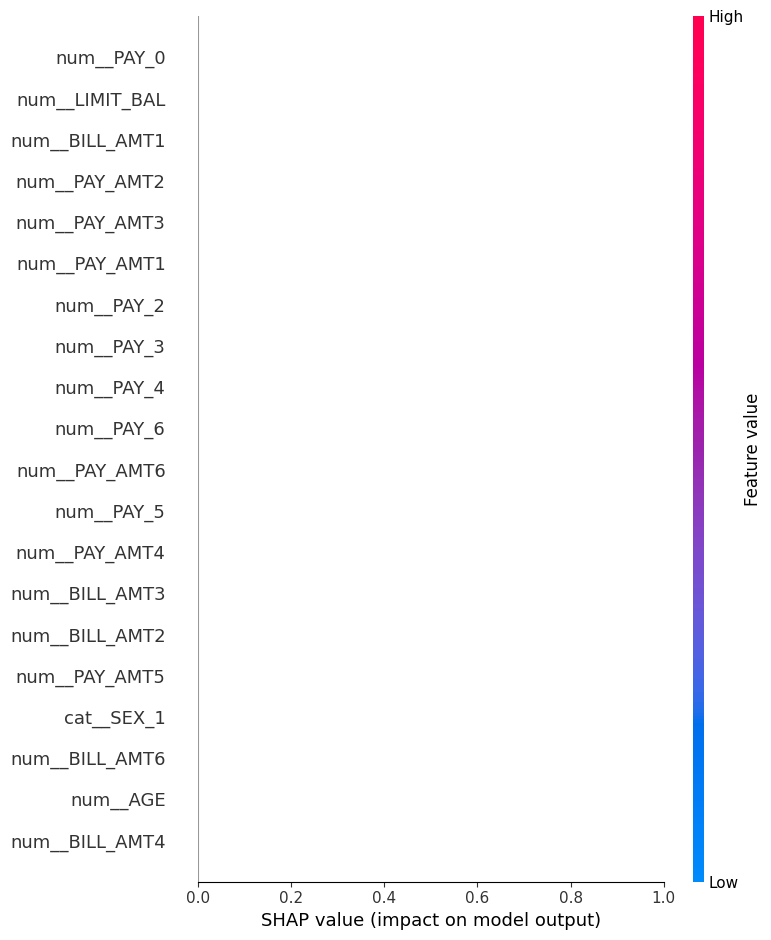

La structure de l'objet shap_values est : (6000, 34)


In [29]:
# 1. Préparation pour l'interrogatoire
# SHAP a besoin de deux choses : le modèle "nu" (sans le pipeline) et les données "préparées".

# On extrait le classifieur final de notre pipeline sauvegardé
final_classifier = final_model.named_steps['classifier']

# On extrait le préprocesseur final
final_preprocessor = final_model.named_steps['preprocessor']

# On prend nos données de test (que le modèle n'a jamais vues) et on les passe dans le préprocesseur.
# C'est pour voir comment le modèle explique ses décisions sur des cas nouveaux.
X_test_processed = final_preprocessor.transform(X_test)
feature_names = final_preprocessor.get_feature_names_out() # On récupère les noms des colonnes
X_test_processed_df = pd.DataFrame(X_test_processed, columns=feature_names)


# 2. L'interrogatoire (calcul des valeurs SHAP)
# On crée un "Explainer" qui est un spécialiste des modèles de type "arbre" comme XGBoost.
explainer = shap.TreeExplainer(final_classifier)

# On lance le calcul. L'explainer analyse chaque prédiction sur le X_test_processed_df
# et détermine la contribution de chaque variable à cette décision.
shap_values = explainer(X_test_processed_df)

# 3. Visualisation des aveux (les graphiques)
# Le summary_plot est le rapport de synthèse de l'enquête.
# Il classe les variables de la plus importante (en haut) à la moins importante.
# Pour chaque variable, il montre si des valeurs élevées (rouge) ou faibles (bleu)
# poussent la prédiction vers 0 ou vers 1.
shap.summary_plot(shap_values, X_test_processed_df, plot_type="beeswarm")


# Initialise le Javascript de SHAP pour l'affichage dans le notebook
shap.initjs()

# Le force_plot est le dossier d'un seul "suspect" (une seule prédiction).
# Il montre pour un client spécifique, quelles variables (en rouge) ont poussé le score vers le haut (défaut de paiement)
# et lesquelles (en bleu) l'ont tiré vers le bas.
print(f"La structure de l'objet shap_values est : {shap_values.shape}")
shap.force_plot(shap_values[0])
# Expliquer la prédiction pour le premier client du set de test
#shap.force_plot(explainer.expected_value, shap_values.values[0,:], X_test_processed_df.iloc[0,:], link="logit")

La force la plus importante est de loin num_PAY_0 = -0.078. Cela signifie que son statut de paiement le 
plus récent (probablement "payé à temps") a très fortement tiré son risque vers le bas. 
Les variables num_PAY_AMT (montants payés) aident aussi.

1.Le modèle commence avec un a priori : le risque de ce client est de 21.85% (la moyenne).

2.Il voit ensuite quelques facteurs de risque (en rouge) qui font légèrement monter ce score.

3.MAIS, il voit surtout des facteurs très positifs (en bleu), en particulier le fait que le client a bien payé sa dernière échéance (num_PAY_0).

4.Les forces bleues ("bon client") sont bien plus fortes que les forces rouges ("client à risque").

5.Au final, elles tirent le score final vers le bas pour l'amener à 15%. C'est donc un client considéré comme moins risqué que la moyenne.